In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score,roc_auc_score, roc_curve
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn import svm

# Get pandas and postgres to work together
import psycopg2 as pg
import pandas.io.sql as pd_sql

# We are also going to do some basic viz
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
plt.style.use('ggplot')
plt.rc('font', size=12)


In [5]:
# Postgres info to connect

connection_args = {
    'host': 'localhost',  # We are connecting to our _local_ version of psql
    'dbname': 'ecommerce',    # DB that we are connecting to
    'port': 5432          # port we opened on AWS
}

# We will talk about this magic Python trick!
connection = pg.connect(**connection_args)

In [6]:
query = ("select e.timestamp, e.visitorid, e.event, e.transactionid, i.itemid, i.property, i.value, c.parentid " 
        "from events as e "
        "left join item_properties as i on e.itemid = i.itemid "
        "left join category as c on c.categoryid = i.value "
        "where i.property = 'categoryid'")

ecommerce_raw_df = pd_sql.read_sql(query, connection)

In [7]:
ecommerce_raw_df.head()

,timestamp,visitorid,event,transactionid,itemid,property,value,parentid
0,1433185063620,529288,view,None,16813,categoryid,1173,805
1,1433185359747,491230,view,None,339411,categoryid,589,1308
2,1433185972123,266698,view,None,361956,categoryid,1279,1606
3,1433187271078,60826,view,None,102306,categoryid,499,986
4,1433185199943,1083695,view,None,360487,categoryid,683,1606


In [8]:
ecommerce_raw_df = ecommerce_raw_df.rename(columns={"value": "Category", "parentid": "Parent_Category"})

In [9]:
ecommerce_raw_df = ecommerce_raw_df.drop(columns=['property'])

In [10]:
ecommerce_raw_df.head()

,timestamp,visitorid,event,transactionid,itemid,Category,Parent_Category
0,1433185063620,529288,view,None,16813,1173,805
1,1433185359747,491230,view,None,339411,589,1308
2,1433185972123,266698,view,None,361956,1279,1606
3,1433187271078,60826,view,None,102306,499,986
4,1433185199943,1083695,view,None,360487,683,1606


In [11]:
ecommerce_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5644678 entries, 0 to 5644677
Data columns (total 7 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   timestamp        object
 1   visitorid        object
 2   event            object
 3   transactionid    object
 4   itemid           object
 5   Category         object
 6   Parent_Category  object
dtypes: object(7)
memory usage: 301.5+ MB


In [12]:
ecommerce_raw_df['Event_Goal'] = ecommerce_raw_df['event'].apply(lambda x: 1 if x=='transaction' else 0)

ecommerce_raw_df['AddtoCart'] = ecommerce_raw_df['event'].apply(lambda x: 1 if x=='addtocart' else 0)

ecommerce_raw_df['timestamp'] = pd.to_datetime(ecommerce_raw_df['timestamp'], unit='ms')

ecommerce_raw_df['Day_of_Week'] = ecommerce_raw_df['timestamp'].dt.dayofweek

In [13]:
ecommerce_raw_df.head()

,timestamp,visitorid,event,transactionid,itemid,Category,Parent_Category,Event_Goal,AddtoCart,Day_of_Week
0,2015-06-01 18:57:43.620,529288,view,None,16813,1173,805,0,0,0
1,2015-06-01 19:02:39.747,491230,view,None,339411,589,1308,0,0,0
2,2015-06-01 19:12:52.123,266698,view,None,361956,1279,1606,0,0,0
3,2015-06-01 19:34:31.078,60826,view,None,102306,499,986,0,0,0
4,2015-06-01 18:59:59.943,1083695,view,None,360487,683,1606,0,0,0


In [14]:
ecommerce_raw_df = pd.get_dummies(ecommerce_raw_df, columns=['Day_of_Week'], drop_first=True)

In [15]:
ecommerce_raw_df.groupby('event').count()

,timestamp,visitorid,transactionid,itemid,Category,Parent_Category,Event_Goal,AddtoCart,Day_of_Week_1,Day_of_Week_2,Day_of_Week_3,Day_of_Week_4,Day_of_Week_5,Day_of_Week_6
event,,,,,,,,,,,,,,
addtocart,149024,149024,0,149024,149024,149024,149024,149024,149024,149024,149024,149024,149024,149024
transaction,43652,43652,43652,43652,43652,43652,43652,43652,43652,43652,43652,43652,43652,43652
view,5452002,5452002,0,5452002,5452002,5451765,5452002,5452002,5452002,5452002,5452002,5452002,5452002,5452002


In [16]:
def get_part_of_day(hour):
    return (
        "Morning" if 5 <= hour <= 11
        else
        "Afternoon" if 12 <= hour <= 17
        else
        "Evening" if 18 <= hour <= 22
        else
        "Night"
    )



In [17]:
ecommerce_raw_df['Time_of_Day'] = ecommerce_raw_df['timestamp'].dt.hour




In [18]:
ecommerce_raw_df.head()



,timestamp,visitorid,event,transactionid,itemid,Category,Parent_Category,Event_Goal,AddtoCart,Day_of_Week_1,Day_of_Week_2,Day_of_Week_3,Day_of_Week_4,Day_of_Week_5,Day_of_Week_6,Time_of_Day
0,2015-06-01 18:57:43.620,529288,view,None,16813,1173,805,0,0,0,0,0,0,0,0,18
1,2015-06-01 19:02:39.747,491230,view,None,339411,589,1308,0,0,0,0,0,0,0,0,19
2,2015-06-01 19:12:52.123,266698,view,None,361956,1279,1606,0,0,0,0,0,0,0,0,19
3,2015-06-01 19:34:31.078,60826,view,None,102306,499,986,0,0,0,0,0,0,0,0,19
4,2015-06-01 18:59:59.943,1083695,view,None,360487,683,1606,0,0,0,0,0,0,0,0,18


In [19]:
ecommerce_raw_df['Time_of_Day'] = ecommerce_raw_df['Time_of_Day'].apply(get_part_of_day)


In [20]:
ecommerce_raw_df.head()

,timestamp,visitorid,event,transactionid,itemid,Category,Parent_Category,Event_Goal,AddtoCart,Day_of_Week_1,Day_of_Week_2,Day_of_Week_3,Day_of_Week_4,Day_of_Week_5,Day_of_Week_6,Time_of_Day
0,2015-06-01 18:57:43.620,529288,view,None,16813,1173,805,0,0,0,0,0,0,0,0,Evening
1,2015-06-01 19:02:39.747,491230,view,None,339411,589,1308,0,0,0,0,0,0,0,0,Evening
2,2015-06-01 19:12:52.123,266698,view,None,361956,1279,1606,0,0,0,0,0,0,0,0,Evening
3,2015-06-01 19:34:31.078,60826,view,None,102306,499,986,0,0,0,0,0,0,0,0,Evening
4,2015-06-01 18:59:59.943,1083695,view,None,360487,683,1606,0,0,0,0,0,0,0,0,Evening


In [21]:
ecommerce_raw_df = pd.get_dummies(ecommerce_raw_df, columns=['Time_of_Day'], drop_first=True)

In [22]:
ecommerce_raw_df['visitorid'].value_counts()

1150086    12637
310759      9750
638482      7693
530559      6060
152963      6011
           ...  
1325021        1
1390485        1
418512         1
695629         1
827860         1
Name: visitorid, Length: 1236032, dtype: int64

In [23]:
ecom_df = ecommerce_raw_df.drop_duplicates(subset=['timestamp', 'visitorid'])

In [24]:
ecom_df.describe()

,Event_Goal,AddtoCart,Day_of_Week_1,Day_of_Week_2,Day_of_Week_3,Day_of_Week_4,Day_of_Week_5,Day_of_Week_6,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night
count,2.497491e+06,2.497491e+06,2.497491e+06,2.497491e+06,2.497491e+06,2.497491e+06,2.497491e+06,2.497491e+06,2.497491e+06,2.497491e+06,2.497491e+06
mean,7.976005e-03,2.727818e-02,1.622536e-01,1.563057e-01,1.516734e-01,1.375953e-01,1.105898e-01,1.214267e-01,3.317513e-01,1.160325e-01,3.221609e-01
std,8.895162e-02,1.628929e-01,3.686834e-01,3.631450e-01,3.587041e-01,3.444748e-01,3.136235e-01,3.266225e-01,4.708423e-01,3.202639e-01,4.673043e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [25]:
ecom_df['visitorid'].value_counts()

1150086    6610
530559     3370
152963     2888
895999     2451
163561     2374
           ... 
1225784       1
724826        1
846939        1
336771        1
827860        1
Name: visitorid, Length: 1236032, dtype: int64

In [26]:
ecom_df.columns

Index(['timestamp', 'visitorid', 'event', 'transactionid', 'itemid',
       'Category', 'Parent_Category', 'Event_Goal', 'AddtoCart',
       'Day_of_Week_1', 'Day_of_Week_2', 'Day_of_Week_3', 'Day_of_Week_4',
       'Day_of_Week_5', 'Day_of_Week_6', 'Time_of_Day_Evening',
       'Time_of_Day_Morning', 'Time_of_Day_Night'],
      dtype='object')

RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density.

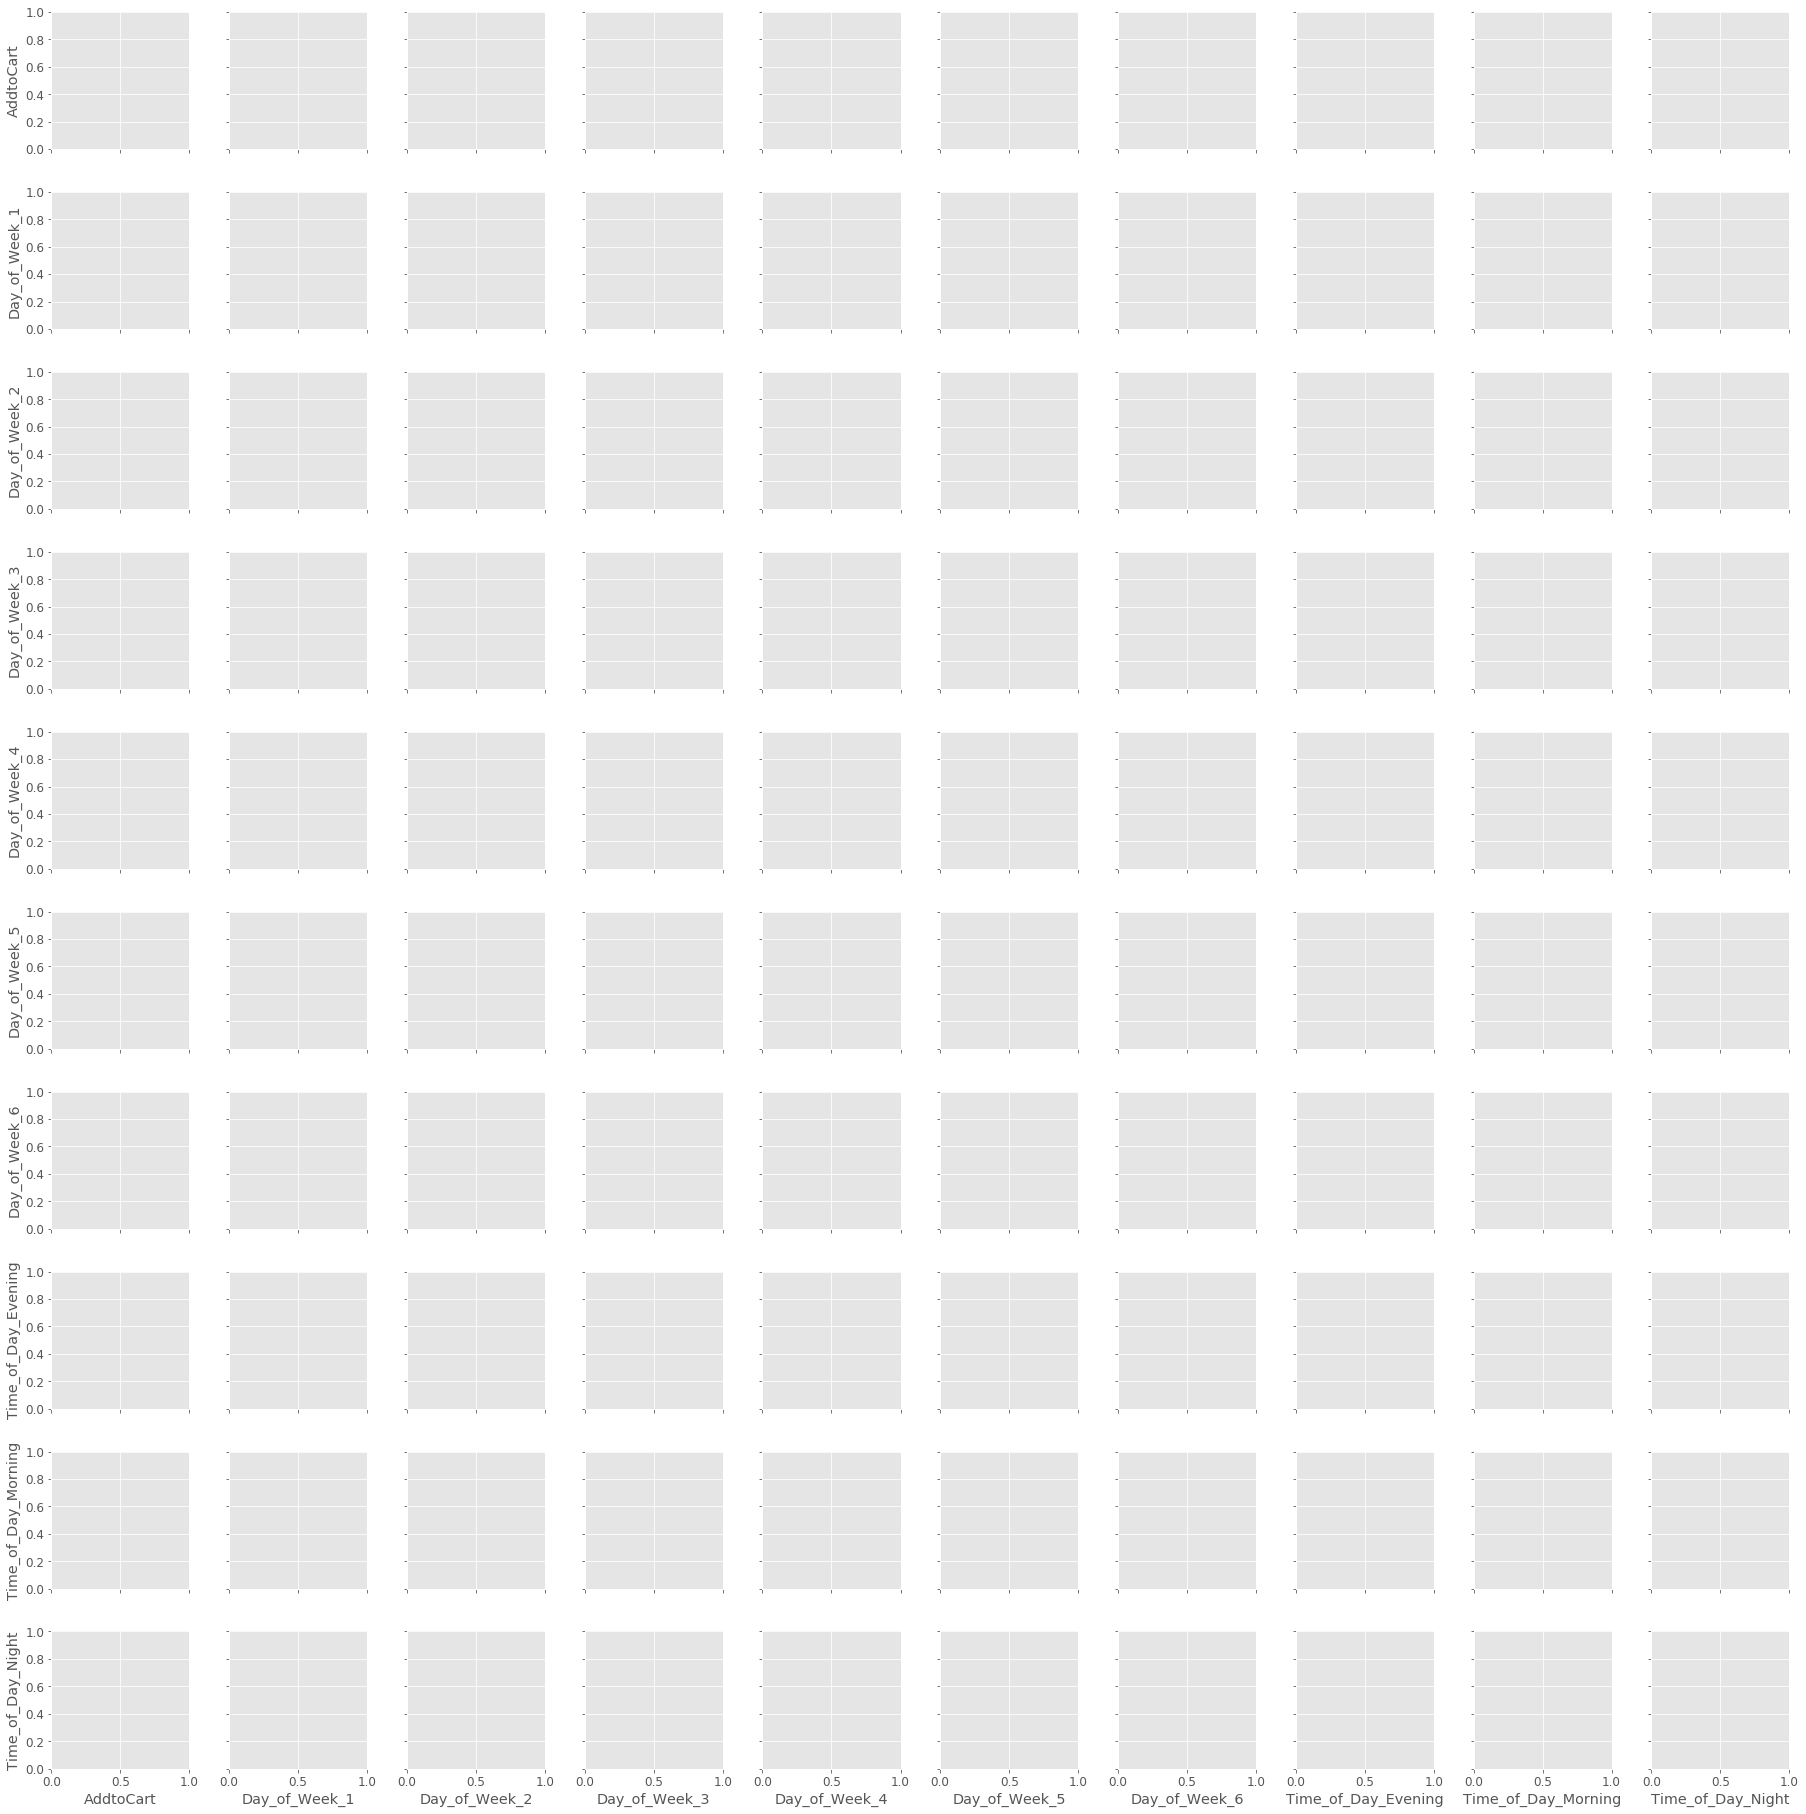

In [27]:
def plot_features(df, sample_size=500):
    
    sample = (df.drop(['timestamp', 'visitorid', 'event', 'transactionid', 'itemid',
       'Category', 'Parent_Category'],axis=1)
                .sample(1000, random_state=44)) 
    sns.pairplot(sample,hue='Event_Goal', plot_kws=dict(alpha=.3, edgecolor='none'))

plot_features(ecom_df)

In [28]:
vis_list = pd.DataFrame(ecom_df['visitorid'].value_counts() > 100)

In [29]:
vis_list = vis_list.loc[vis_list['visitorid'] == True].index

In [30]:
vis_list

Index(['1150086', '530559', '152963', '895999', '163561', '286616', '684514',
       '371606', '861299', '76757',
       ...
       '1144130', '1083704', '279406', '577459', '653779', '1310923', '356005',
       '1224022', '1140886', '509109'],
      dtype='object', length=382)

In [34]:
visitorid_list = list(ecom_df['visitorid'])

visitorid_list = list(dict.fromkeys(visitorid_list))

new_vis_list = sorted(visitorid_list)

In [35]:
ecom_df.columns

Index(['timestamp', 'visitorid', 'event', 'transactionid', 'itemid',
       'Category', 'Parent_Category', 'Event_Goal', 'AddtoCart',
       'Day_of_Week_1', 'Day_of_Week_2', 'Day_of_Week_3', 'Day_of_Week_4',
       'Day_of_Week_5', 'Day_of_Week_6', 'Time_of_Day_Evening',
       'Time_of_Day_Morning', 'Time_of_Day_Night'],
      dtype='object')

In [38]:
new_temp_df = pd.DataFrame()
for visitor in new_vis_list:
    temp_df = ecommerce_raw_df[ecommerce_raw_df['visitorid'] == visitor]
    temp_df = temp_df[['timestamp','visitorid','Previous_Visits','Event_Goal','Time_of_Day_Evening','Time_of_Day_Morning', 'Time_of_Day_Night']]
    temp_df.sort_values(by='timestamp')
    for i, ind in enumerate(temp_df.index):
        temp_df['Previous_Visits'][ind] = i
    new_temp_df = pd.concat([new_temp_df, temp_df])
    

KeyError: "['Previous_Visits'] not in index"

In [ ]:
new_temp_df.Event_Goal.value_counts()

In [ ]:
def visit_count(df, visitorid_list):
    # sort df chronilogically
    df.sort_values(by='timestamp')
    # loop through list of visitor ids
    for visitor in visitorid_list:
    # for each visitor id, count up from 0 and put it in the Previous Visits column
        df['Previous_Visits'] = df['']
    
    
    
    

In [ ]:
ecommerce_raw_df.groupby('event').sum()

# ---------------------------- Modeling -----------------------------

In [ ]:
#ecommerce_raw_df.columns
ecom_df.columns

In [ ]:
#y = ecommerce_raw_df["Event_Goal"]
#X = ecommerce_raw_df[['Time_of_Day_Evening','Time_of_Day_Morning', 'Time_of_Day_Night']]

y = ecom_df['Event_Goal']
X = ecom_df[['AddtoCart',
       'Day_of_Week_1', 'Day_of_Week_2', 'Day_of_Week_3', 'Day_of_Week_4',
       'Day_of_Week_5', 'Day_of_Week_6', 'Time_of_Day_Evening',
       'Time_of_Day_Morning', 'Time_of_Day_Night']]

In [ ]:
#X.info()

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
X_under, y_under = RandomUnderSampler(random_state=42).fit_sample(X,y)



In [ ]:
np.unique(y_under, return_counts=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.3, random_state=42)

In [ ]:
nb = GaussianNB()
nb.fit(X_train, y_train)
nb.score(X_test, y_test)

In [ ]:
nb = BernoulliNB()
nb.fit(X_train,y_train)
nb.score(X_test,y_test)

In [ ]:
model_svm = svm.SVC(kernel='linear')

In [ ]:
# 2. Fit a model on the training data
model_svm.fit(X_train, y_train)

# 3a. Predict the values using the test data
y_pred = model_svm.predict(X_test)

In [ ]:
# 3b. Score the model
accuracy_score(y_test,y_pred)

# take a look at the predictions
confusion_matrix(y_test,y_pred)

In [ ]:
# 1. Create a suppor vector classifier model
model_svm2 = svm.SVC(kernel='rbf', gamma = 0.001)

# 2. Fit a model on the training data
model_svm2.fit(X_train, y_train)

# 3a. Predict the values using the test data
y_pred2 = model_svm2.predict(X_test)

In [ ]:
# 3b. Score the model
accuracy_score(y_test,y_pred2)

# take a look at the predictions
confusion_matrix(y_test,y_pred2)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
knn = KNeighborsClassifier(n_neighbors=7)
model = knn.fit(X_train, y_train)
y_pred = knn.predict(X_train)


print(metrics.accuracy_score(y_train, y_pred))

In [ ]:
def quick_test(model, X, y):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
    model.fit(xtrain, ytrain)
    return model.score(xtest, ytest)

def quick_test_afew_times(model, X, y, n=10):
    return np.mean([quick_test(model, X, y) for j in range(n)])

In [ ]:
randomforest = RandomForestClassifier(n_estimators=100)
quick_test_afew_times(randomforest, X_train, y_train)

In [ ]:
lm2 = LogisticRegression(solver= 'liblinear', C=10)
lm2.fit(X_train, y_train)
#lm2.score(X_train, y_train)

y_pred = lm2.predict(X_train)


print(metrics.accuracy_score(y_train, y_pred))

In [ ]:
def roc(model, title):
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.plot(fpr, tpr,lw=2)
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    #plt.title('{} ROC curve'.format(title))
    print("ROC AUC score = ", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

In [ ]:
roc(lm2, "Logistic")
roc(knn, "KNN")
roc(randomforest, "Random Forest")
plt.savefig('ROC.pdf')

In [ ]:
print("kNN confusion matrix: \n\n", confusion_matrix(y_test, knn.predict(X_test)))

In [ ]:
knn_confusion = confusion_matrix(y_test, knn.predict(X_test))
plt.figure(dpi=300)
sns.heatmap(knn_confusion, cmap=plt.cm.Blues, annot=True, square=True)
           #xticklabels=iris_dataset['target_names'],
           #yticklabels=iris_dataset['target_names'])

plt.xlabel('Predicted Purchased')
plt.ylabel('Actual Purchased')
plt.title('kNN confusion matrix');

def visitor_count(visitorid):
    """ takes an input of """
    for visitor in visitorid:
        

In [ ]:
import pickle
pickle.dump(model, open("my_pickled_model.p", "wb"))

In [ ]:
model.predict(X_test)

In [ ]:
#model.predict([[5,1,0,0]])